# Linear Regression: Prostate Cancer Example

The data below comes from a study by Stamey et al. (1989), which examines the correlation between the level of prostate-specific antigen (PSA). The example is covered in Section 3.2.1 if Haste et al. *Elements of Statistical Learning*.

First, let's load the dataset and see example data from each column.

## Data Exploration and Understanding

In [1]:
import pandas as pd
df = pd.read_csv("../data/prostate.data", sep='\t')

# To download the dataset from the Internet, use this line
# df = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data", sep='\t')

In [2]:
df = df.drop(columns=['Unnamed: 0'])
df.head(5)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
df_train = df[df['train']=='T']
df_test = df[df['train']=='F']

We can then split the data into training and test samples, according to the desription in the chapter: 67 samples for training, 30 for testing. (It's generally helpful to understand the dimensions of the dataset that you are working with, as well.) 

In [4]:
df_train.shape

(67, 10)

In [5]:
df_test.shape

(30, 10)

Next, we look at the pairwise correlations for each pair of variables, as in Table 3.1. We also show an example of showing this as a visual representation using `matplotlib`.

In [6]:
df_train.corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161,0.733155
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166,0.485215
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806,0.227642
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404,0.262938
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358,0.556886
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533,0.489203
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056,0.342428
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000,0.448048
lpsa,0.733155,0.485215,0.227642,0.262938,0.556886,0.489203,0.342428,0.448048,1.000000


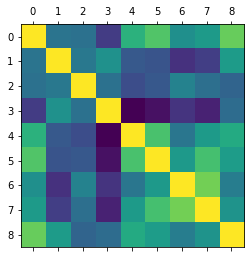

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.matshow(df_train.corr())

In [8]:
df.describe().loc[['mean', 'std']]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329


## Linear Regression: Training, Evaluation, Feature Importance

We'll now perform linear regression on the dataset using Python's scikit-learn library. We import the library and create an instance of a Linear Regression class.

In [9]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

regr = linear_model.LinearRegression()

We must normalize our features to have mean 0 and standard deviation of 1, up to computational errors.

In [10]:
scaler = StandardScaler()
def normalize(df):
    iterator = pd.DataFrame(df.iloc[:,:-1]).items() #Will not change the response, only the predictors.
    for column,_ in iterator:
        column_data = pd.DataFrame(df[column]) # Create dataframe with a single column.
        new_column_array = scaler.fit_transform(column_data) # The scaler transforms the column.
        df[column] = pd.DataFrame(new_column_array) # Update column.
    return df
    
df.describe().loc[['mean', 'std']]
df.head(10)

train = df['train']
df = normalize(df.drop(columns=['train']))
df['train'] = train

In [11]:
df.describe().loc[['mean', 'std']]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,-9.614302e-17,-3.216213e-16,3.433679e-16,-4.721309e-17,-1.327689e-16,8.240831e-17,-1.476482e-16,-1.816989e-16,2.478387
std,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.005195e+00,1.154329


In [12]:
df_train = df[df['train']=='T']
df_test = df[df['train']=='F']

### Creating the inputs and targets

Next, we separate the data into the features that we are use for inputs and the target variable that we are trying to predict (lpsa).

In [13]:
train_features = df_train.loc[:,'lcavol':'pgg45']
train_targets = df_train.loc[:,'lpsa']

test_features = df_test.loc[:,'lcavol':'pgg45']
test_targets = df_test.loc[:,'lpsa']

Here we can see an example of a vector in the training set, and an example target variable.

In [14]:
train_features.head(1)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-1.645861,-2.016634,-1.872101,-1.030029,-0.525657,-0.867655,-1.047571,-0.868957


### Training the model

Training the model is a one-line call to fit.

In [15]:
regr.fit(train_features,train_targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Evaluating the model

We evaluate the model using the test set, creating our target predictions. We ultimately compare the target prediction values to the true targets in the test set.

In [16]:
target_predict = regr.predict(test_features)

* *Mean squared error* represents a measure of prediction error. 
* *Variance score* is the coefficient of prediction (R^2)

In [17]:
# The mean squared error and RSS (by hand)
print("Mean squared error: %.2f" % np.mean((target_predict - test_targets) ** 2))
print("RSS: %.2f" % np.sum((target_predict - test_targets) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(train_features, train_targets))

Mean squared error: 0.52
RSS: 15.64
Variance score: 0.69


In [18]:
mean_squared_error(target_predict,test_targets)

0.5212740055076002

In [19]:
def Z_score(X_train, y_true, y_pred, beta_hat):
    '''
    Returns the Z-scores of the model with coefficients beta_hat.
    The data is encoded in X_train and y_true:
        X_train is a (numpy) array (N, p + 1), where p is the number of predictors.
        y_true is a vector of length N.
    y_pred ia vector of length N, and is the prediction of the model on X.
    '''
    N = len(y_true)
    p = X_train.shape[1] - 1
    variance_y_est = (1/(N-p-1)) * np.sum(np.square(y_true - y_pred)) # Estimative of the variance of y.
    diag = np.diag(np.linalg.inv(np.matmul(np.transpose(X_train),X_train))) # Diagonal of (X^t X)^{-1}.
    Z = (1/np.sqrt(variance_y_est)) * np.multiply(beta_hat, np.sqrt(1/diag))
    return Z

In [20]:
# The predicted values of y on the training set.
y_pred = regr.predict(train_features)

# prepare beta
beta_hat = regr.coef_
beta_hat = np.concatenate([np.array([regr.intercept_]), beta_hat])

# prepare X
column_of_ones = np.ones((train_features.shape[0],1))
X = np.concatenate([column_of_ones, train_features], axis = 1)

# Z-scores 
columns = ['Intercept'] + train_features.columns.to_list()
Zscores = np.array([Z_score(X, train_targets.to_numpy(), y_pred, beta_hat)])
Zscores_df = pd.DataFrame(data=Zscores, columns=columns, index=['Z-score'] )
Zscores_df

,Intercept,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
Z-score,27.598203,5.36629,2.750789,-1.395909,2.055846,2.469255,-1.866913,-0.146681,1.73784


### Dropping less significant features

We can examine the intercept and coefficient values learned by the model, as below. One of the advantages of a linear regression model is that it is intepretable: larger absolute values of standardized coefficients (i.e., normalized with respect to the standard deviation) reflect higher feature importance.

First, let's have a look at the estimated coefficients.

In [21]:
print('Intercept: \n', regr.intercept_, '\nCoefficients: \n', regr.coef_)

Intercept: 
 2.464932922123745 
Coefficients: 
 [ 0.67601634  0.26169361 -0.14073374  0.20906052  0.30362332 -0.28700184
 -0.02119493  0.26557614]


Below we can see that training the model on fewer features actually reduces mean squared error 

In [22]:
train_features_small = df_train.loc[:,['lcavol','lweight','svi']]
test_features_small = df_test.loc[:,['lcavol','lweight','svi']]
regr.fit(train_features_small,train_targets)
target_predict_small = regr.predict(test_features_small)

# The mean squared error and RSS (by hand)
print("Mean squared error: %.2f" % np.mean((target_predict_small - test_targets) ** 2))
print("RSS: %.2f" % np.sum((target_predict_small - test_targets) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(train_features_small, train_targets))

Mean squared error: 0.40
RSS: 12.02
Variance score: 0.64
